# Instructions

This simulates retail sales for cigarettes, Juul and other e-cigarettes. We are interested in what conclusions you draw from this data about Juul's performance and market impact and how you visualize them. 

Feel free to use whatever means you prefer for your analysis and communication of it and its results. What you send back should be able to stand on its own, i.e., we should be able to understand it without requiring additional narration.

Please only use RMA and ignore CRMA and SRMA geographies for this analysis.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
# import dask.dataframe as dd

In [3]:
sku = pd.read_csv('sku_new.csv'); sku.head()

,SKU,sku_id,unit_sales,sku_legend,sku_legend_text,sku_tf_idf
0,JUUL Total,0,–,JUUL-ELECTRONIC SMOKING DEVICES,juulelectronic smoking devices,devices smoking juulelectronic
1,Cigarettes Total,1,"75,083,502,411",CIGARETTES,cigarettes,cigarettes
2,E-Cigs Total,2,"939,305,632",ELECTRONIC SMOKING DEVICES,electronic smoking devices,electronic devices smoking
3,JUUL Refill Kits,3,"27,211,643",JUUL ELCTRNC SMKNG ACSRY MIINT DISPOSABLE 4 CT...,juul elctrnc smkng acsry miint disposable ct,elctrnc disposable miint
4,JUUL Refill Kits,4,"7,979,019",JUUL ELCTRNC SMKNG ACSRY BRUULE DISPOSABLE 4 C...,juul elctrnc smkng acsry bruule disposable ct,elctrnc disposable bruule


In [4]:
sales = pd.read_csv('sales_new.csv'); sales.head()

,Geography,Product,Time,Dollar Sales,Unit Sales,SKU,end_time,start_time
0,Circle K Florida-RMA - Conv,CIGARETTES,4 Weeks Ending 01-31-16,28921840.49,4968512.070,Cigarettes Total,2016-01-31,2016-01-03
1,Circle K Florida-RMA - Conv,CIGARETTES,4 Weeks Ending 02-28-16,30276220.80,5139634.753,Cigarettes Total,2016-02-28,2016-01-31
2,Circle K Florida-RMA - Conv,CIGARETTES,4 Weeks Ending 03-27-16,31535167.82,5366848.000,Cigarettes Total,2016-03-27,2016-02-28
3,Circle K Florida-RMA - Conv,CIGARETTES,4 Weeks Ending 04-24-16,31693487.95,5420033.091,Cigarettes Total,2016-04-24,2016-03-27
4,Circle K Florida-RMA - Conv,CIGARETTES,4 Weeks Ending 05-22-16,31390945.73,5380230.139,Cigarettes Total,2016-05-22,2016-04-24


## Aggregating Sales Nation Wide
We'll aggretate sales across all RMA's for each product by end_time of sale

In [5]:
sales.SKU.unique()

array(['Cigarettes Total', 'E-Cigs Total', 'JUUL Refill Kits',
       'JUUL Devices'], dtype=object)

In [6]:
national_sales = sales.drop(['Geography', 'Product','Time','start_time'],axis = 1)\
    .groupby(by = ['SKU', 'end_time'])\
    .agg(np.sum)\
    .reset_index()
national_sales.columns = ['sku', 'end_time', 'dollar_sales', 'unit_sales']
national_sales.head()

,sku,end_time,dollar_sales,unit_sales
0,Cigarettes Total,2016-01-31,8.700012e+08,1.326638e+08
1,Cigarettes Total,2016-02-28,9.031296e+08,1.368401e+08
2,Cigarettes Total,2016-03-27,9.260665e+08,1.407221e+08
3,Cigarettes Total,2016-04-24,9.392742e+08,1.431413e+08
4,Cigarettes Total,2016-05-22,9.558178e+08,1.463879e+08


## Forecasting Juul's Growth

How long would it take for Juul to achieve a 10% market share (in $) of all tobacco products being sold across the United States? 

For this we'll assume there are no sales outside RMA Geo regions (RMA regions encompass all nation wide sales)

In [276]:
var = 'dollar_sales'

def get_market_share(var):
    
    juul_share = national_sales[national_sales.sku.apply(lambda x: 
                                        x in ['JUUL Devices', 'JUUL Refill Kits'])]\
        .loc[:, ['end_time', var]].groupby('end_time').agg(np.sum).reset_index()
    
    other_share = national_sales[national_sales.sku.apply(lambda x: 
                                        x not in ['JUUL Devices', 'JUUL Refill Kits'])]\
        .loc[:, ['end_time', var]].groupby('end_time').agg(np.sum).reset_index()
    
    share_df = pd.merge(juul_share, 
                        other_share,
                        on = 'end_time', 
                        suffixes = ("_juul", "_other"))
    
    share_df['juul_market_share'] = (share_df[var + '_juul']/(share_df[var + '_juul'] + share_df[var + '_other'])) * 100
    share_df['end_time'] = share_df.end_time.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return share_df.loc[:,['end_time', 'juul_market_share']]

market_share = get_market_share('dollar_sales')
market_share = market_share.set_index(keys = 'end_time')
market_share = pd.Series(market_share.juul_market_share)

print(market_share); print(market_share.shape)

end_time
2016-01-31    0.055513
2016-02-28    0.062819
2016-03-27    0.072577
2016-04-24    0.085328
2016-05-22    0.093281
2016-06-19    0.094297
2016-07-17    0.100432
2016-08-14    0.124225
2016-09-11    0.160103
2016-10-09    0.204196
2016-11-06    0.221927
2016-12-04    0.237462
2017-01-01    0.331324
2017-01-29    0.448120
2017-02-26    0.516734
2017-03-26    0.566018
2017-04-23    0.601849
2017-05-21    0.655228
2017-06-18    0.720222
2017-07-16    0.867948
2017-08-13    0.902322
2017-09-10    0.879865
2017-10-08    0.967622
2017-11-05    1.227410
2017-12-03    1.586709
2017-12-31    2.027225
2018-01-28    2.428421
Name: juul_market_share, dtype: float64
(27,)


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
market_share.plot(style = ".")
plt.show()

A quick check of the scatter plot of Juul's dollar market share % over time tells us that a linear model wont be good fit for forecasting Juul's growth. For this we'll try to fit an time series forecast. 

Juul's marekt share % seems to be trending upwards. A quick check of the rolling mean that our data is trending upwards. The upward trending standard deviation also confirm that the difference between the market share at Tn and Tn+1 is also increasing. 

We can conduct a dickey-fuller test on our time series data with the null hypothesis that our data has a trend. A high p value confirms this. 

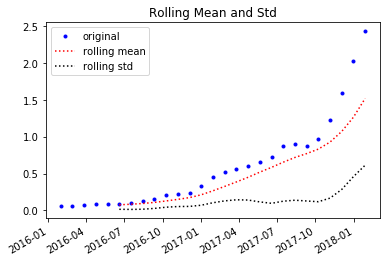

Test Statistic                  3.692245
p-value                         1.000000
#Lags Used                      9.000000
Number of Observations Used    17.000000
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller

def plot_rolling(ts, p):
    
    rm = ts.rolling(window = p, center = False).mean()
    rs = ts.rolling(window = p, center = False).std()
    
    fig, ax = plt.subplots()
    
    orig = ax.plot(ts, ".", color = "blue", label = "original")
    mean = ax.plot(rm, ":", color = "red", label = "rolling mean")
    std = ax.plot(rs, ":", color = "black", label = "rolling std")
    
    fig.autofmt_xdate()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Std")
    plt.show(block=False)

def df_test(ts):
        print(pd.Series(adfuller(np.array(ts))[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']))
        
plot_rolling(market_share, 6); df_test(market_share)        

We can modify the original market share time series with a log transformation to reduce the effect of the increasing market share %. There is still and upward trend but the rolling standard deviation appears to be stationary. 

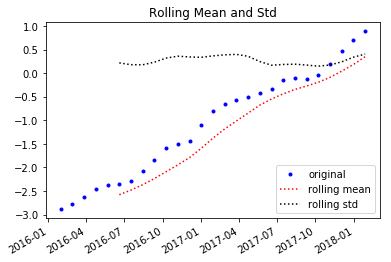

Test Statistic                  0.773141
p-value                         0.991190
#Lags Used                      9.000000
Number of Observations Used    17.000000
dtype: float64


In [10]:
market_share_log = np.log(market_share)
plot_rolling(market_share_log, 6); df_test(market_share_log)

## Extracting Seasonal Components

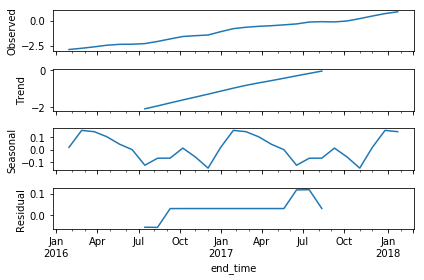

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(market_share_log, model = 'additive', filt = None, freq = 12)
fig = result.plot()

We can create a stationary process by differencing the log transformation of Juul's market share. At a p-value low of .001 for the d-f test, we're certain we have a stationary process. 

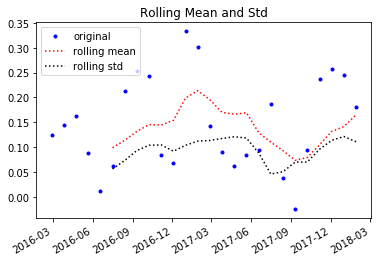

Test Statistic                 -3.966092
p-value                         0.001599
#Lags Used                      9.000000
Number of Observations Used    16.000000
dtype: float64


In [23]:
log_diff = market_share_log.diff(1).dropna()
plot_rolling(log_diff, 6); df_test(log_diff)

It's clear from the `seasonal_decompose` function that there is at least some seasonality - so we'll use a seasonal arima model. Next, we plot the auto-correlation and partial auto-correlation function to determine our auto-regressive and moving average components. 

* Auto Regression: today(t) = mean + phi * yesterday(t-1) + phi * yesterday(t-2) + ... + noise
* Moving Average: today(t) = mean + noise + theta * noise(t-1) + theta * noise(t-2) + . . .

The ACF has significant lag coefficients on the 95% level only at 1. The PACF has significant coefficients at lag 2. Both the ACF and PACF tail off. This suggests some combination of both an AR and MA model. This suggests that the best AR and MA components could be either 1 or 2. 

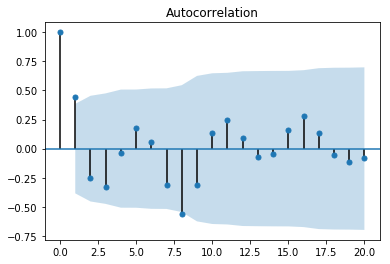

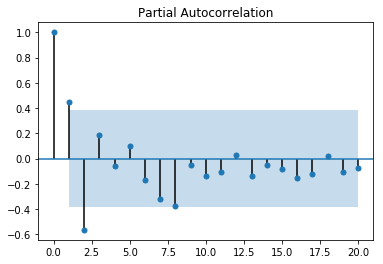

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(log_diff, alpha = .05, lags = 20)
plot_pacf(log_diff, alpha = .05, lags = 20)
plt.show()

The seasonal difference appears to be yearly - peaking in January. Since our data is monthly we'll take the 12th order difference from the log transformation. 

Since the autocorrelation doesn't show any significant coefficients at lag 12 in the seasonal ACF and PACF function, we won't assign any AR or MA components to the seaosnal part our model.

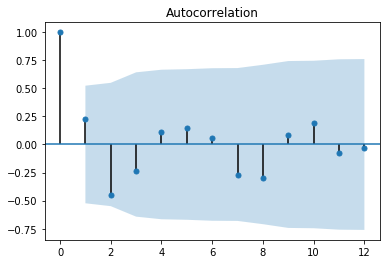

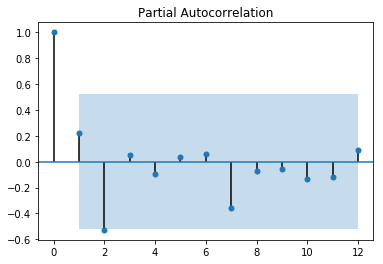

In [51]:
log_diff_seasonal = (log_diff - log_diff.shift(12)).dropna()
plot_acf(log_diff_seasonal, alpha = .05, lags = 12)
plot_pacf(log_diff_seasonal, alpha = .05, lags = 12)
plt.show()

## Fitting the Model

We'll try with AR = 1 (p), MA = 1 (q) , first order differnce (d), and our 12 period seasonal difference.

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

pdq = [(1,1,1), (2,1,1), (1,1,2), (2,1,2)]

def model_sarima(pdq_arg):
    model = SARIMAX(market_share_log
                , trend='ct'
                , order = pdq_arg
                , seasonal_order = (0,0,0,12)
                , enforce_stationarity = False)
    results = model.fit(maxiter=200, method = 'powell')
    return results.summary()

def get_results(model_results):
    df = model_results.tables[0].data; df = pd.DataFrame(df)
    model_name = df.loc[1, 1]; aic = df.loc[2, 3]; bic = df.loc[3,3]
    df = model_results.tables[2].data; df = pd.DataFrame(df); ljung_box_p = df.loc[1,1]
    df = {model_name: {'aic' : aic
                       , 'bic' : bic
                       , 'ljung_p': ljung_box_p}}
    return df

#### We use the AIC and BIC measures to compare our ARIMA models (the lower the AIC/BIC the better). Under this criteria our best performing model are the (1,1,2) and (2,1,2) models. 

We can then compare Ljung-Box Stats and P values to evaluate model fit. A Ljung-Box test is essentially a chi-squared test with:
* *Null hypothesis - autocorrelation coefficients for chosen lags are 0 (ie model fits well)*
* *Alternative hypothesis - autocorrelation coefficients for chosen lags are not 0 (ie model does not fit well)*

The (1,1,2) model and the (2,1,2) models each have .49 and .88 respectively as their Ljung p-value - meaining we're more certain the (2,1,2) model is a better fit for our data. We'll chose this as our final model.

In [167]:
for args in pdq:
    print(get_results(model_sarima(args)))

Optimization terminated successfully.
         Current function value: -1.068911
         Iterations: 3
         Function evaluations: 183
{'SARIMAX(1, 1, 1)': {'aic': '-47.721', 'bic': '-41.242', 'ljung_p': '0.53'}}
Optimization terminated successfully.
         Current function value: -1.121736
         Iterations: 7
         Function evaluations: 497
{'SARIMAX(2, 1, 1)': {'aic': '-48.574', 'bic': '-40.799', 'ljung_p': '0.93'}}
Optimization terminated successfully.
         Current function value: -1.009227
         Iterations: 11
         Function evaluations: 835
{'SARIMAX(1, 1, 2)': {'aic': '-42.498', 'bic': '-34.723', 'ljung_p': '0.49'}}
Optimization terminated successfully.
         Current function value: -1.061235
         Iterations: 7
         Function evaluations: 571
{'SARIMAX(2, 1, 2)': {'aic': '-43.307', 'bic': '-34.236', 'ljung_p': '0.88'}}


## Model Forecasting

In [232]:
final_model = SARIMAX(market_share_log
                , trend='ct'
                , order = (2,1,2)
                , seasonal_order = (0,0,0,12)
                , enforce_stationarity = False)
model_fit = final_model.fit(maxiter=200, method = 'powell')

forecasts = model_fit.forecasts[0]
actuals = model_fit.data.orig_endog
df = pd.DataFrame.from_dict({'forecast': forecasts,
                        'actual': actuals}).iloc[1:,:]

Optimization terminated successfully.
         Current function value: -1.061235
         Iterations: 7
         Function evaluations: 571


In [252]:
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

forecast = go.Scatter(
    x = df.index,
    y = df.forecast,
    name = "forcecast"
)
actual = go.Scatter(
    x = df.index,
    y = df.actual,
    name = "actual"
)

data = [forecast, actual]

layout = dict(title = 'Fitted ARIMA model (2,1,2)',
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Log of Market Share %')
              )
fig = dict(data = data, layout = layout)
py.iplot(fig)

Our model looks pretty good. Lets add in a 2 year forecast

In [254]:
two_year_forecast = pd.DataFrame(model_fit.forecast(steps = 24))

In [258]:
future_forecast = go.Scatter(x = two_year_forecast.index,
                            y = np.array(two_year_forecast.iloc[:,0]),
                            name = "future")

data = [forecast, actual, future_forecast]
fig = dict(data = data, layout = layout)
py.iplot(fig)

We can raise e to the power of the log market share to get back to the original market share %.

In [275]:
df['actual_percent'] = df.actual.apply(lambda x: np.e ** x)
df['forecast_percent'] = df.forecast.apply(lambda x: np.e ** x)
two_year_forecast['forecast_percent'] = two_year_forecast.iloc[:,0].apply(lambda x: np.e ** x)[0:12]

forecast = go.Scatter(
    x = df.index,
    y = df.forecast_percent,
    name = "forcecast"
)
actual = go.Scatter(
    x = df.index,
    y = df.actual_percent,
    name = "actual"
)
future_forecast = go.Scatter(x = two_year_forecast.index,
                            y = np.array(two_year_forecast.iloc[:,1]),
                            name = "future")


data = [forecast, actual, future_forecast]

layout = dict(title = 'Fitted ARIMA model (2,1,2)',
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Juul Market Share %')
              )
fig = dict(data = data, layout = layout)
py.iplot(fig)

## RESULTS
Based on the provided data and the resultant SARIMA model we created, our answer to our original question is that Juul would receive 10% market cap of all tobacco productucts nationwide in around October - November of 2018.

## DISCLAIMER

ARIMA models by nature only model future values based on what happened in the past. In this case, it would not take into account real world events such as: 

* a trade war causing Juul to increase their per unit cost, resulting in overall less units sold. 
* a successful social media campaign leading to a boom in sales
* selling into a new market which had previously been untapped
* the addition of new product lines -- both from Juul (complimentary goods) and competitors (substitutional ones)
* negative press or increased regulation (decreasing sales)

Our data is somewhat limited in that we only had 27 time points for market share as a function of time, lowering the quailty of the overall model we could build. It goes without saying that the more datapoints to ingest the better the resultant model. 

This could have been fixed with any interpolation method (eg linear) to fill in the gaps between dates which we had data for. 

Lastly, I chose the 10% market share arbitrarily for the purpose of this exercise. 

## Further Applications with the Provided Data

1. Continuing on the time series track:
    * model data for market share as a percentage of units sold
    * forecast performance of specific geo regions or specific goods
2. Unsupervised learning applications:
    * use clustering to create profiles for geo regions. are there geo regions where one specific refill kit is more popular? Are there regions where unit sales are high but dollar sales are low?
3. Other Business Questions:
    * are smokers becoming Juulers? Are cigarette sales declining in areas while Juul's sales are increasing?
    * $ Sales / units sold - are goods becoming more or less expensive? 